In [1]:
import numpy as np
import os

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from PIL import Image

In [4]:
def get_data_path():
    return '/Users/thibaultdesfontaines/data'

In [5]:
print(tf.version.VERSION)

2.1.0


In [6]:
data_dir = os.path.join(get_data_path(), "leaf-classification")
train_dir = os.path.join(data_dir, 'train_images')
validation_dir = os.path.join(data_dir, 'validation_images')
test_dir = os.path.join(data_dir, 'test_images')

In [7]:
CLASS_NAMES = [x for x in sorted(os.listdir(str(train_dir))) if x[0] != '.']
CLASS_NAMES = np.array(CLASS_NAMES)
print("Number of classes: {}".format(len(CLASS_NAMES)))

Number of classes: 99


In [8]:
checkpoint_dir = "/Users/thibaultdesfontaines/data/training_1/"
latest = tf.train.latest_checkpoint(checkpoint_dir)
print("{}".format(latest))

/Users/thibaultdesfontaines/data/training_1/cp.ckpt


In [9]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [10]:
def create_model():

    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        MaxPooling2D(),
        Dropout(0.2),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Dropout(0.2),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(99)
    ])

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    return model

In [11]:
model = create_model()

model.summary()

model.load_weights(latest)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0

In [12]:
to_predict = {}
for image_path in os.listdir(test_dir):
    to_predict[image_path] = {}
    to_predict[image_path]['done'] = False

In [13]:
len(to_predict)

594

In [14]:
list_ds = tf.data.Dataset.list_files(os.path.join(test_dir, '*'))

In [15]:
for f in list_ds.take(5):
    print(f.numpy())

/Users/thibaultdesfontaines/data/leaf-classification/test_images/567.jpg
/Users/thibaultdesfontaines/data/leaf-classification/test_images/686.jpg
/Users/thibaultdesfontaines/data/leaf-classification/test_images/534.jpg
/Users/thibaultdesfontaines/data/leaf-classification/test_images/594.jpg
/Users/thibaultdesfontaines/data/leaf-classification/test_images/474.jpg


In [16]:
def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size.
    return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [17]:
def get_name(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-1]

In [18]:
def process_path(file_path):
    name = get_name(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, name

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [20]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [21]:
BATCH_SIZE = 600

In [22]:
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [23]:
train_ds = prepare_for_training(labeled_ds)

image_batch, label_batch = next(iter(train_ds))

In [24]:
predictions = model.predict_classes(image_batch)

In [25]:
import matplotlib.pyplot as plt

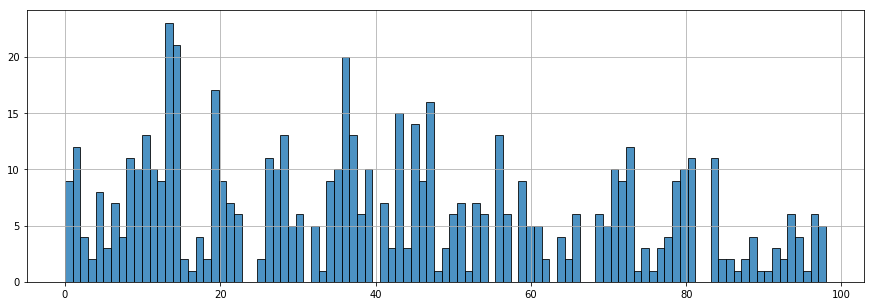

In [26]:
plt.figure(figsize=(15, 5))
plt.hist(predictions, edgecolor='k', alpha=0.8, bins=99)
plt.grid()
plt.show()

In [27]:
label_batch = np.array(label_batch)

In [28]:
pred_dict = {}
for pred, label in zip(predictions, label_batch):
    pred_dict[label] = pred

In [29]:
len(pred_dict)

594

In [30]:
prediction_matrix = np.zeros((len(pred_dict), 100), dtype=int)
for i, label in enumerate(pred_dict):
    index_value = int(label.split('.')[0])
    prediction_matrix[i][0] = index_value
    prediction_value = pred_dict[label]
    prediction_matrix[i][prediction_value+1] = 1

In [31]:
prediction_matrix

array([[ 640,    0,    0, ...,    0,    0,    0],
       [ 205,    0,    0, ...,    0,    0,    0],
       [1012,    0,    0, ...,    0,    0,    0],
       ...,
       [1455,    0,    0, ...,    0,    0,    0],
       [ 221,    0,    0, ...,    0,    0,    0],
       [1214,    0,    0, ...,    0,    0,    0]])

In [32]:
prediction_matrix.shape

(594, 100)

In [33]:
import pandas as pd

In [34]:
df = pd.DataFrame(prediction_matrix)

In [35]:
df.columns = ['id']+list(CLASS_NAMES) 

In [36]:
df.to_csv('predictions.csv', index=False)